## 서론

텍스트 분류는 감정 분석, 스팸 탐지, 해시 태그 예측 등과 같은 다양한 사용 머신 러닝 문제를 해결하는 데 사용할 수 있습니다. 

이 노트북은 SageMaker BlazingText를 사용하여 지도학습의 단일 또는 다중 레이블 텍스트 분류를 수행하는 방법을 보여주고 영화 리뷰 데이터를 사용하여 실제적으로 모델을 구축 및 배포하는 방법을 보여줍니다. 

BlazingText는 멀티 코어 CPU 또는 GPU를 사용하여 몇 분 안에 10억 단어 이상의 단어로 모델을 학습시키는 동시에 최첨단 딥 러닝 텍스트 분류 알고리즘과 동등한 성능을 달성할 수 있습니다. BlazingText는 사용자 지정 CUDA 커널을 사용하여 GPU 가속을 활용하도록 fastText 텍스트 분류기를 확장합니다.

## 셋업

먼저 다음을 지정해 보겠습니다.

- 학습 및 모델 데이터에 사용할 S3 버킷 및 prefix 를 설정합니다. 이 설정은 노트북 인스턴스, 학습 및 호스팅과 동일한 리전 내에 있어야 합니다. 버킷을 지정하지 않으면 SageMaker SDK는 동일한 리전에서 미리 정의된 명명 규칙에 따라 기본 버킷을 생성합니다. 
- 세이지메이커에 데이터에 대한 액세스 권한을 부여하는 데 사용되는 IAM 역할 ARN 을 설정합니다. SageMaker Python SDK에서**get_execution_role** 메서드를 사용하여 가져올 수 있습니다.

In [3]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

# This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf
role = get_execution_role()

bucket = sess.default_bucket()  # Replace with your own bucket name if needed
prefix = "blazingtext/supervised"  # Replace with the prefix under which you want to store the data if needed

### 데이터 준비

웹에서 텍스트 분류 모델을 학습시키려는 데이터세트를 다운로드하겠습니다. BlazingText는 공백으로 구분된 토큰이 있는 단일 전처리된 텍스트 파일을 기대하며 파일의 각 줄에는 단일 문장과 "\__label\__" 접두사가 붙은 레이블이 포함되어야 합니다.

이 노트북에서 사용할 데이터는 네이버 영화 리뷰 데이터입니다. 데이터의 원본은 다음 [Github](https://github.com/e9t/nsmc/) 에서 다운로드 받을 수 있으며, 총 200,000 개 리뷰로 구성된 데이터로 영화 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1, 부정인 경우 0을 표시한 레이블로 구성되어져 있습니다. 



In [4]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fe96890e978>)

pandas 패키지를 활용하여 데이터를 로드하고 분석을 해봅니다.

In [5]:
import pandas as pd

train_data_raw = pd.read_table('ratings_train.txt')
test_data_raw = pd.read_table('ratings_test.txt')

In [6]:
test_data_raw.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [7]:
print('훈련용 리뷰 개수 :',len(train_data_raw)) # 학습용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있습니다. id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시할 예정입니다. 결국 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 모델이 되어야 합니다.

한글 데이터는 띄어쓰기가 되어 있지 않아도 의미를 이해하는데 어려움이 없다는 점을 한번 생각해 보도록 합니다.

In [8]:
print('테스트용 리뷰 개수 :',len(test_data_raw)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


### 데이터 처리

#### 중복 데이터 처리

In [9]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data_raw['document'].nunique(), train_data_raw['label'].nunique()

(146182, 2)

In [10]:
train_data_raw.drop_duplicates(subset=['document'], inplace=True)

<AxesSubplot:>

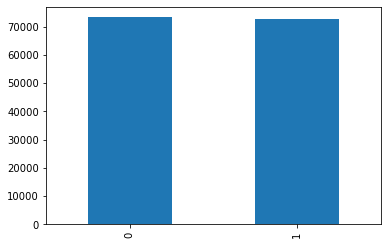

In [11]:
train_data_raw['label'].value_counts().plot(kind = 'bar')

0과 1의 데이터가 balanced 되어 있는것을 확인할 수 있습니다.

In [12]:
train_data_raw.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,73342
1,1,72841


레이블이 0이나 1인 데이터 중, Null 값이 있는지 확인합니다. 다음 코드 실행 후 True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미입니다.

In [13]:
train_data_raw.isnull().values.any()

True

In [14]:
train_data_raw.isnull().sum()

id          0
document    1
label       0
dtype: int64

리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다는 결과값이 나오고 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력해 볼 수 있습니다.

In [15]:
train_data_raw.loc[train_data_raw.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
train_data_raw = train_data_raw.dropna(how = 'any') # Null 값이 존재하는 행 제거

In [17]:
train_data_raw.isnull().values.any()

False

#### 데이터 전처리

train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. train_data 로부터 한글만 남기고 제거하기 위해서 Regular Expression(정규 표현식) 을 사용해보겠습니다.

영어를 예로 들면 영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]입니다. 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 이를 응용하면 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있습니다. 예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같습니다.

In [18]:
import re
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 됩니다. 우선 자음과 모음에 대한 범위를 지정해보겠습니다. 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ 힣 와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 다음 [유니코드 문서](https://www.unicode.org/charts/PDF/U3130.pdf) 를 참고하시기 바랍니다.

* ㄱ ~ ㅎ: 3131 ~ 314E
* ㅏ ~ ㅣ: 314F ~ 3163

해당 범위 내에 포함된 음절들은 다음 [유니코드 문서](https://www.unicode.org/charts/PDF/UAC00.pdf) 에서 확인할 수 있습니다.

위 범위 지정을 모두 반영하여 train_data 에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해 봅니다.

In [19]:
# 한글과 공백을 제외하고 모두 제거
train_data_raw['document'] = train_data_raw['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [20]:
train_data_raw.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


다음은 영화 리뷰 중 특수문자나 영어, 숫자만으로 이루어져 있는 리뷰들이 있을 수 있으므로 이런 데이터들은 위 과정에서 Null 내지는 white space 로 변경되었을 것입니다. train_data 에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인해보겠습니다.

In [21]:
train_data_raw['document'] = train_data_raw['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경

In [22]:
import numpy as np

In [23]:
train_data_raw['document'].replace('', np.nan, inplace=True)

In [24]:
train_data_raw.isnull().sum()

id            0
document    789
label         0
dtype: int64

In [25]:
train_data_raw = train_data_raw.dropna(how = 'any')

In [26]:
train_data_raw.to_csv('ratings_train_stage.txt', index=False, sep='\t')

training 세트에 대한 전처리가 완료되었으므로 이를 test/validation 세트에도 적용시키도록 합니다.

In [27]:
test_data_raw.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data_raw['document'] = test_data_raw['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data_raw['document'] = test_data_raw['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data_raw['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data_raw = test_data_raw.dropna(how='any') # Null 값 제거

In [28]:
'전처리 후 테스트용 샘플의 개수 : ' + str(len(test_data_raw))

'전처리 후 테스트용 샘플의 개수 : 48852'

In [29]:
test_data_raw.to_csv('ratings_test_stage.txt', index=False, sep='\t')

In [30]:
!head ratings_train_stage.txt -n 5

id	document	label
9976970	아 더빙 진짜 짜증나네요 목소리	0
3819312	흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 솔직히 재미는 없다평점 조정	0


BlazingText 알고리즘으로 분류 문제를 학습하기 위해서는 말뭉치 데이터의 각 문장의 클래스 레이블 앞에 \__label__을 접두사로 붙여야 합니다. 변환 예시는 아래를 참조해 주세요.

\__label__0 아 더빙.. 진짜 짜증나네요 목소리

\__label__1 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나

In [31]:
def preprocess_text(corpus_path, output_path):
    with open(corpus_path, 'r', encoding='utf-8') as f, \
        open(output_path, 'w', encoding='utf-8') as fw:
        next(f)
        for line in f:
            # Remove tab
            _, sentence, label = line.strip().split('\t') 
            if not sentence: continue
            fw.writelines('__label__' + label + ' '+ sentence + '\n')    

In [32]:
corpus_path = 'ratings_train_stage.txt'
output_path = 'ratings_train_preprocessd'
preprocess_text(corpus_path, output_path)

In [33]:
!head ratings_train_preprocessd -n 5

__label__0 아 더빙 진짜 짜증나네요 목소리
__label__1 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
__label__0 너무재밓었다그래서보는것을추천한다
__label__0 교도소 이야기구먼 솔직히 재미는 없다평점 조정
__label__1 사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다


In [34]:
corpus_path = 'ratings_test_stage.txt'
output_path = 'ratings_test_preprocessd'
preprocess_text(corpus_path, output_path)

In [35]:
!head ratings_test_preprocessd -n 5

__label__1 굳 ㅋ
__label__0 뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
__label__0 지루하지는 않은데 완전 막장임 돈주고 보기에는
__label__0 만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠
__label__1 음악이 주가 된 최고의 음악영화


### S3 경로 설정

In [36]:
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

sess.upload_data(path='ratings_train_preprocessd', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='ratings_test_preprocessd', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

모델 아티팩트(Model Artifact)가 저장될 S3의 경로를 설정합니다.

In [37]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [38]:
s3_train_data

's3://sagemaker-ap-northeast-2-806174985048/blazingtext/supervised/train'

In [39]:
s3_validation_data

's3://sagemaker-ap-northeast-2-806174985048/blazingtext/supervised/validation'

In [40]:
s3_output_location

's3://sagemaker-ap-northeast-2-806174985048/blazingtext/supervised/output'

### 모델 Training

In [41]:
region_name = boto3.Session().region_name
# container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
container = sagemaker.image_uris.retrieve(region=region_name, framework = "blazingtext")
print('SageMaker BlazingText 컨테이너 위치: {} ({})'.format(container, region_name))

SageMaker BlazingText 컨테이너 위치: 306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/blazingtext:1 (ap-northeast-2)


SageMaker BlazingText는 Word2Vec의 구현과 유사하게 네거티브 샘플링(Negative Sampling)을 사용하여 CPU 및 GPU(들)에서 CBOW(Continuous Bag-of-Words) 및 스킵 그램(Skip-gram) 아키텍처를 효율적으로 구현합니다. GPU 구현은 고도로 최적화된 CUDA 커널을 사용합니다. 자세한 내용은 [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354)를 참조하세요. 

또한, BlazingText는 CBOW 및 스킵 그램 모드로 서브 워드(subwords) 임베딩 학습을 지원합니다. 이를 통해 BlazingText는 out-of-vocabulary(OOV)를 생성할 수 있습니다.
서브 워드 임베딩 학습은 [notebook (text8 데이터셋 서브 워드 임베딩)](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb)을 참조하세요.

스킵 그램 및 CBOW 외에도 SageMaker BlazingText는 효율적인 미니 배치 및 행렬 연산을 수행하는 "배치 스킵 그램(Batch Skipgram)" 모드도 지원합니다. ([BLAS Level 3 routines](https://software.intel.com/en-us/mkl-developer-reference-fortran-blas-level-3-routines)) 이 모드는 여러 CPU 노드에 걸쳐 분산된 Word2Vec의 학습을 가능하게 하여 보다 빠른 학습이 가능합니다. 자세한 내용은 [*Parallelizing Word2Vec in Shared and Distributed Memory*](https://arxiv.org/pdf/1604.04661.pdf)를 참조하세요.

BlazingText는 텍스트 분류를 위한 교사 학습(supervised learning)도 지원하며, 사용자 지정 CUDA 커널을 사용하여 GPU 가속을 활용하도록 FastText 텍스트 분류기를 확장합니다. 이 모델은 최신 딥러닝 텍스트 분류 알고리즘과 동등한 성능을 달성하면서 멀티 코어 CPU 또는 GPU를 사용하여 몇 분 안에 10억 단어 이상을 학습할 수 있습니다. 자세한 내용은 [알고리즘 설명서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html)를 참조하세요.


아래 표는 BlazingText에서 지원하는 모드입니다.

|          Modes         	| cbow (서브워드 학습 지원) 	| skipgram (서브워드 학습 지원) | batch_skipgram | supervised |
|:----------------------:	|:----:	|:--------:	|:--------------:| :--------------:|
|   단일 CPU 인스턴스  	|   ✔  	|     ✔    	|        ✔       	|  ✔  |
|   단일 GPU 인스턴스  	|   ✔  	|     ✔    	|              X  	|  ✔ (1 GPU 인스턴스만 지원)  |
| 다중 CPU 인스턴스 	|   X 	|     X     	|        ✔       	 |  X    |

In [42]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.2xlarge',
                                         train_volume_size=30,
                                         train_max_run=360000,
                                         input_mode='File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


BlazingText 하이퍼파라메터의 자세한 설정 방법은 [이 문서](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html)를 참조해 주세요.

In [43]:
bt_model.set_hyperparameters(mode="supervised",
                            epochs=30,
                            min_count=2,
                            learning_rate=0.005,
                            vector_dim=100,
                            early_stopping=True,
                            patience=4,  # Number of epochs to wait before early stopping if no progress on the validation set is observed
                            buckets=2000000, # Number of hash buckets to use for word n-grams
                            min_epochs=5,
                            word_ngrams=2)

### 하이퍼파라미터 튜닝 작업 설정

Estimator 를 정의한 후에는 조정하려는 하이퍼파라미터와 가능한 값을 지정할 수 있습니다. 세 가지 유형의 하이퍼 파라미터가 있습니다.
- 범주형 매개변수는 불연속 집합에서 하나의 값을 가져와야 합니다. 가능한 값 목록을 `Categorical 매개 변수(list) `에 전달하여 정의합니다.
- 연속 매개 변수는 `연속 매개 변수, Continuous parameters (min, max) `로 정의 된 최소값과 최대값 사이의 실수 값을 취할 수 있습니다.
- 정수 매개 변수는 `정수 매개 변수, Integer parameters (min, max) `로 정의된 최소값과 최대값 사이의 정수값을 취할 수 있습니다.

*가능하면 값을 최소 제한적 유형으로 지정하는 것이 거의 항상 가장 좋습니다.예를 들어, 0.01에서 0.2 사이의 연속형 값으로 learning rate 을 조정하는 것이 값이 0.01, 0.1, 0.15 또는 0.2 인 범주형 매개 변수로 조정하는 것보다 더 나은 결과를 얻을 수 있습니다.*

하이퍼파라미터의 전체 목록은 아마존 세이지메이커 설명서의 [BlazingText 하이퍼파라미터](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) 를 참조하십시오.

In [44]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.05, 0.15),
    "vector_dim": IntegerParameter(32, 300),
}

다음으로 조정하려는 목표 지표와 정의를 지정합니다. 여기에는 교육 작업의 CloudWatch 로그에서 해당 지표를 추출하는 데 필요한 정규식 (Regex) 이 포함됩니다. Built in 알고리즘 `BlazingText` 알고리즘을 사용하고 있기 때문에 `train:mean_rho`와 `validation:accuracy` 라는 두 가지 사전 정의 된 메트릭을 내보내고 아래에서 볼 수 있듯이 `validation:accuracy` 를 모니터링하기로 결정했습니다. 이 경우 메트릭 이름만 지정하면 되고 정규식을 제공할 필요가 없습니다. 자체 알고리즘을 가져오면 알고리즘이 자체적으로 메트릭을 방출합니다. 이 경우 여기에 `MetricDefinition` 객체를 추가하여 정규식을 통해 해당 지표의 형식을 정의해야 SageMaker가 CloudWatch 로그에서 이러한 지표를 추출하는 방법을 알 수 있습니다.

In [45]:
objective_metric_name = "validation:accuracy"
objective_type = "Maximize"

이제 `HyperparameterTuner` 객체를 만들어 보겠습니다.
- 위에서 만든 `BlazingText` Estimator
- 하이퍼파라미터 범위
- 객관적인 지표 이름 및 정의
- 총 실행할 학습 작업 수 및 병렬로 실행할 수 있는 교육 작업 수와 같은 리소스 구성 조정

In [47]:
tuner = HyperparameterTuner(
    bt_model,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=6,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

이제 하이퍼 파라미터가 설정되었으므로 데이터 채널과 알고리즘 간의 핸드셰이크를 준비해 보겠습니다. 이를 위해서는 데이터 채널에서 `SageMaker.inputs.trainingInput` 객체를 만들어야 합니다. 그런 다음 이 객체들은 알고리즘에서 사용되는 딕셔너리에 배치됩니다.

In [48]:
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/plain",
    s3_data_type="S3Prefix",
)
data_channels = {"train": train_data, "validation": validation_data}

`Estimator` 객체가 있고, 이 객체에 대한 하이퍼 매개 변수를 설정했으며, 알고리즘과 연결된 데이터 채널이 있습니다. 남은 것은 알고리즘을 학습시키는 것 뿐입니다. 알고리즘 학습에는 몇 가지 단계가 필요합니다. 

1. 먼저 `Estimator` 클래스를 만들 때 요청한 인스턴스가 프로비저닝되고 적절한 라이브러리로 설정됩니다. 
2. 그런 다음 채널의 데이터가 인스턴스로 다운로드됩니다. 이 작업이 완료되면 교육 작업이 시작됩니다. 프로비저닝 및 데이터 다운로드는 데이터 크기에 따라 다소 시간이 걸립니다. 따라서 학습 작업에 대한 교육 로그를 받기 시작하기까지 몇 분 정도 걸릴 수 있습니다.
3. 또한 데이터 로그는 훈련 작업이 `min_epochs`를 실행한 후 매 Epoch의 유효성 검사 데이터에 대한 정확도를 인쇄합니다. 이 메트릭은 알고리즘의 품질에 대한 프록시입니다.

작업이 완료되면 “작업 완료” 메시지가 인쇄됩니다. 학습된 모델은 추정기에서 `output_path` 로 설정된 S3 버킷에서 찾을 수 있습니다.

## 하이퍼파라미터 튜닝 작업 시작

이제 *fit ()* 함수를 호출하여 하이퍼파라미터 튜닝 작업을 시작할 수 있습니다. 하이퍼파라미터 조정 작업이 생성된 후 SageMaker 콘솔로 이동하여 완료될 때까지 하이퍼파라미터 조정 작업의 진행률을 추적할 수 있습니다.

이 작업을 완료하는 데 약 12분 정도 걸립니다.

In [ ]:
%%time

tuner.fit(inputs=data_channels, logs=True)

..................................................................................................................................................................................................................!
CPU times: user 979 ms, sys: 52.4 ms, total: 1.03 s
Wall time: 21min 43s


### 하이퍼파라미터 튜닝 작업의 결과 분석

튜닝 작업을 완료한 후 (또는 작업이 아직 실행 중인 동안에도) 아래 코드를 사용하여 결과를 분석하여 각 하이퍼파라미터가 모델의 성능에 어떤 영향을 미치는지 이해할 수 있습니다.

In [50]:
sm_client = boto3.Session().client("sagemaker")

tuning_job_name = tuner.latest_tuning_job.name
tuning_job_name

'blazingtext-220406-0747'

### 하이퍼파라미터 튜닝 작업 진행률 추적

튜닝 작업을 시작한 후 `describe_tuning_job` API를 호출하여 진행 상황을 확인할 수 있습니다. describe-tuning-job 의 출력은 튜닝 작업의 현재 상태에 대한 정보가 포함된 JSON 객체입니다. `list_training_jobs_for_tuning_job` 을 호출하여 튜닝 작업이 시작된 학습 작업의 자세한 목록을 볼 수 있습니다.

In [51]:
tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

status = tuning_job_result["HyperParameterTuningJobStatus"]
if status != "Completed":
    print("Reminder: the tuning job has not been completed.")

job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" % job_count)

is_minimize = (
    tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]["Type"]
    != "Maximize"
)
objective_name = tuning_job_result["HyperParameterTuningJobConfig"][
    "HyperParameterTuningJobObjective"
]["MetricName"]

6 training jobs have completed


In [52]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2022, 4, 6, 7, 53, 59, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 0.8009999990463257},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2022, 4, 6, 8, 0, 42, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:ap-northeast-2:806174985048:training-job/blazingtext-220406-0747-004-d17efc1d',
 'TrainingJobName': 'blazingtext-220406-0747-004-d17efc1d',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2022, 4, 6, 7, 55, 34, tzinfo=tzlocal()),
 'TunedHyperParameters': {'learning_rate': '0.12133708623491694',
                          'vector_dim': '252'}}


### 모든 결과를 `DataFrame` 으로 가져오기

모든 학습 작업의 하이퍼 파라미터와 객관적인 메트릭을 나열하고 최상의 목표 메트릭으로 학습 작업을 선택할 수 있습니다.

In [53]:
import pandas as pd

tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 6
{'lowest': 0.7972000241279602, 'highest': 0.8009999990463257}


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,learning_rate,vector_dim,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,0.121337,252.0,blazingtext-220406-0747-004-d17efc1d,Completed,0.8010,2022-04-06 07:55:34+00:00,2022-04-06 08:00:42+00:00,308.0
0,0.138186,261.0,blazingtext-220406-0747-006-513e814e,Completed,0.7996,2022-04-06 08:03:28+00:00,2022-04-06 08:08:36+00:00,308.0
4,0.074222,248.0,blazingtext-220406-0747-002-d5014813,Completed,0.7994,2022-04-06 07:48:47+00:00,2022-04-06 07:53:49+00:00,302.0
3,0.064744,300.0,blazingtext-220406-0747-003-6543b83d,Completed,0.7989,2022-04-06 07:55:24+00:00,2022-04-06 08:01:11+00:00,347.0
1,0.149343,223.0,blazingtext-220406-0747-005-0cf743ec,Completed,0.7979,2022-04-06 08:03:07+00:00,2022-04-06 08:07:30+00:00,263.0
5,0.088248,153.0,blazingtext-220406-0747-001-fdbe6c40,Completed,0.7972,2022-04-06 07:48:47+00:00,2022-04-06 07:52:24+00:00,217.0


### 가장 잘 학습된 모델 배포
학습이 완료되면 학습된 모델을 Amazon SageMaker 실시간 호스팅 엔드포인트로 배포할 수 있고 모델에서 예측 (또는 추론) 을 할 수 있습니다. 학습할 때와 동일한 유형의 인스턴스에서 호스팅할 필요는 없습니다. 일반적으로 추론을 위해 트레이닝에 비해 컴퓨팅 파워가 덜 필요하고, 인스턴스 엔드포인트가 오랫동안 가동되어 실행되기 때문에 추론을 위해 더 저렴한 인스턴스를 선택하는 것이 좋습니다.

- `ml.c4.4xlarge` - 컴퓨팅 최적화 인스턴스로서 고성능 프로세서의 이점을 활용하는 애플리케이션에 이상적입니다.
- `ml.m4.xlarge` - 범용 인스턴스로서 컴퓨팅, 메모리 및 네트워킹 리소스의 균형을 제공하며 다양한 워크로드에 사용할 수 있습니다.

In [54]:
from sagemaker.serializers import JSONSerializer

text_classifier = tuner.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=JSONSerializer()
)


2022-04-06 08:00:42 Starting - Preparing the instances for training
2022-04-06 08:00:42 Downloading - Downloading input data
2022-04-06 08:00:42 Training - Training image download completed. Training in progress.
2022-04-06 08:00:42 Uploading - Uploading generated training model
2022-04-06 08:00:42 Completed - Training job completed
-----!

In [55]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [56]:
sentences = ["재미있게 봤습니다. 제 점수는요 100점 만점에 80점 드리겠습니다.",
            "스토리가 너무 단방향이라 재미가 없고 성우 더빙도 그닥이네요..."]

tokenized_sentences = [' '.join(nltk.word_tokenize(sent)) for sent in sentences]
payload = {"instances" : tokenized_sentences, "configuration": {"k": 2}}

In [59]:
payload

{'instances': ['재미있게 봤습니다 . 제 점수는요 100점 만점에 80점 드리겠습니다 .',
  '스토리가 너무 단방향이라 재미가 없고 성우 더빙도 그닥이네요 ...'],
 'configuration': {'k': 2}}

In [61]:
response = text_classifier.predict(payload)

In [62]:
predictions = json.loads(response)
print(json.dumps(predictions, indent=2))

[
  {
    "label": [
      "__label__1",
      "__label__0"
    ],
    "prob": [
      0.998494565486908,
      0.001525494852103293
    ]
  },
  {
    "label": [
      "__label__0",
      "__label__1"
    ],
    "prob": [
      1.000009298324585,
      1.067403172783088e-05
    ]
  }
]


### 정리
엔드포인트는 [SageMaker 가격 페이지](https://aws.amazon.com/sagemaker/pricing/) 를 기준으로 배포된 시간에 따라 요금이 청구되므로 더 이상 사용하지 않을 때는 삭제해야 합니다.

In [63]:
text_classifier.delete_endpoint()